In [1]:
%reload_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.signal as sig
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from keras.models import Model, Sequential, load_model

from util import util
from util.logUtil import LOG

Using TensorFlow backend.


In [27]:
# variables
macDir = '/Users/etto/Desktop/tpDatasets/'
winDir = 'E:/SAA_DATA/predictiveMaintenance/'
osDir = winDir
data_folder = '../../storedData/'

# pak alleen de bearings met temperatuur
train_bearings_abbr = ['1_1', '1_2', '2_1', '3_1']
test_bearings_abbr = ['1_4', '1_5', '1_6', '1_7', '2_4', '2_5', '3_3']
train_bearings = ['Bearing{:s}'.format(bearing) for bearing in train_bearings_abbr]
test_bearings = ['Bearing{:s}'.format(bearing) for bearing in test_bearings_abbr]

train_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in train_bearings]
test_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in test_bearings]

# keys to use
keyHSpec = 'horSpec'
keyVSpec = 'vertSpec'
keyTempTimstamps = 'tempTimestamps'
keyAccTimestamps = 'timestamps'
keyTemps = 'temperature'

In [45]:
testspecs = [
    ['1_4', 339],
    ['1_5', 1610],
    ['1_6', 1460],
    ['1_7', 7570],
    ['2_4', 1390],
    ['2_5', 3090],
    ['3_3', 820]
]

In [29]:
# utility functions
def getDataFrame(bearingPath, key):
    return pd.read_hdf(path_or_buf=bearingPath, key=key)

def plotTrainResults(X, Y, rulModel, history):
    plt.plot(history.history['loss'])
    plt.show()

    plt.figure()
    predictions = rulModel.predict(X)
    plt.plot(predictions)
    plt.plot(Y)
    plt.show()

def getModelName(layersizes, epochs, kenmerk):
    modelname = 'models/rulModel_' + kenmerk + '_'
    for size in layersizes:
        modelname += '{:d}_'.format(size)
    modelname += '1_ep{:d}.h5'.format(epochs)
    return modelname

def evaluate_spectro(modelnames, spectro, RUL_value, plotname=''):
    # True Y values
    nr_samples = len(spectro)
    Y_values = np.array([10 * (nr_samples - i) + RUL_value for i in range(1, nr_samples + 1)])

    models = [load_model(mname) for mname in modelnames]  # type: Model
    predictions = [(model.predict(spectro), np.sqrt(model.evaluate(spectro, Y_values))) for model in models]

    x_ax_values = [10 * i for i in range(nr_samples)]

    nr = 0
    for (prediction, rms) in predictions:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(x_ax_values, prediction,label='Predicted RUL')

        plt.plot(x_ax_values, Y_values,label='Actual RUL')
        plt.title(modelnames[nr] + ' - RMS: {:.0f}'.format(rms))
        plt.ylabel('RUL (s)')
        plt.xlabel('Running Time (s)')
        plt.legend()

        if len(plotname) > 0:
            plt.savefig('plots/' + plotname, bbox_inches='tight', dpi=300)  # 600
        else:
            plt.show()

        nr += 1

## bepaal X en Y

In [42]:
# bepaal temperatuur per spectrum
def getTempsForBearing(bearing_path):
    temps_train = []
    
    with pd.HDFStore(bearing_path) as store:
        tempTimestampsDf = store.get(keyTempTimstamps)
        specTimestampsDf = store.get(keyAccTimestamps)
        tempDf = store.get(keyTemps)

        # alle temperaturen
        allTempTimestamps = np.array([])
        allTemps = np.array([])
        for i in range(len(tempTimestampsDf[0])):
            allTempTimestamps = np.append(allTempTimestamps, tempTimestampsDf[0][i])
            allTemps = np.append(allTemps, tempDf[0][i])

        for i in range(len(specTimestampsDf[0])):
            specTs = specTimestampsDf[0][i]
            ind = np.searchsorted(allTempTimestamps, specTs)
            if ind >= len(allTempTimestamps):
                ind = len(allTempTimestamps) - 1
            temps_train.append(allTemps[ind])

    return np.array(temps_train)


In [43]:
spectros_train_hor = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in train_files]
spectros_train_vert = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in train_files]

spectros_test_hor = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in test_files]
spectros_test_vert = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in test_files]

X_train = np.concatenate((np.concatenate(spectros_train_hor, axis=0),
                          np.concatenate(spectros_train_vert, axis=0),
                          all_temps), 
                          axis=1)

train_temps = np.array([])
for bearing_path in train_files:
    train_temps = np.append(train_temps, getTempsForBearing(bearing_path))
train_temps = train_temps.reshape((len(train_temps),1))

test_temps = []
for bearing_path in test_files:
    tts = getTempsForBearing(bearing_path)
    test_temps.append(tts.reshape(len(tts),1))

print(np.shape(all_temps))
print(np.shape(X_train))

Y_train = []
for spectro in spectros_train_hor:
    nr_samples = len(spectro)
    Y_train_nw = np.array([10 * (nr_samples - i) for i in range(1, nr_samples +1)])
    Y_train = np.append(Y_train, Y_train_nw)
    
print(np.shape(Y_train))

(5100, 1)
(5100, 2563)
(5100,)


In [39]:
# dropout 0.2 op alle plaatsen
def trainModel_01(X, Y, layersizes, epochs, kenmerk):
    input_dim = np.shape(X)[1]

    rulModel = Sequential()
    rulModel.add(Dropout(0.2, input_shape=(input_dim,)))
    rulModel.add(Dense(layersizes[0], input_dim=input_dim, activation='relu', name='layer1'))
    rulModel.add(Dropout(0.2))
    for i in range(1, len(layersizes)):
        rulModel.add(Dense(layersizes[i], activation='relu', name='layer{:d}'.format(i + 1)))
        rulModel.add(Dropout(0.2))
    rulModel.add(Dense(1, activation='linear', name='output_layer'))
    rulModel.compile(loss='mean_squared_error', optimizer='adam')
    history = rulModel.fit(X, Y, epochs=epochs, shuffle=True, verbose=1)
    rulModel.save(getModelName(layersizes, epochs, kenmerk))

    plotTrainResults(X, Y, rulModel, history)

    return rulModel, history

Epoch 1/100
5100/5100 [==============================] - 3s 567us/step - loss: 102490228.0596: 6s - loss: 145369276 - ETA: 1s - loss: 1136889
Epoch 2/100
5100/5100 [==============================] - 1s 184us/step - loss: 80698664.0502
Epoch 3/100
5100/5100 [==============================] - 1s 181us/step - loss: 76240233.81960s - loss: 7722829
Epoch 4/100
5100/5100 [==============================] - 1s 172us/step - loss: 70842225.8573
Epoch 5/100
5100/5100 [==============================] - 1s 172us/step - loss: 66913254.53180s - loss: 6
Epoch 6/100
5100/5100 [==============================] - 1s 285us/step - loss: 66269412.3733
Epoch 7/100
5100/5100 [==============================] - 1s 263us/step - loss: 66173104.3137
Epoch 8/100
5100/5100 [==============================] - 1s 178us/step - loss: 65685614.8706
Epoch 9/100
5100/5100 [==============================] - 1s 199us/step - loss: 65912019.9278
Epoch 10/100
5100/5100 [==============================] - 1s 172us/step - loss: 6506

5100/5100 [==============================] - 1s 260us/step - loss: 27080111.1812
Epoch 88/100
5100/5100 [==============================] - 1s 212us/step - loss: 25414781.2675
Epoch 89/100
5100/5100 [==============================] - 1s 195us/step - loss: 24337533.2753
Epoch 90/100
5100/5100 [==============================] - 2s 312us/step - loss: 25683043.8008
Epoch 91/100
5100/5100 [==============================] - 1s 279us/step - loss: 25104959.5796
Epoch 92/100
5100/5100 [==============================] - 1s 261us/step - loss: 26748744.8282
Epoch 93/100
5100/5100 [==============================] - 1s 193us/step - loss: 25897854.5004
Epoch 94/100
5100/5100 [==============================] - 1s 187us/step - loss: 24760871.4165
Epoch 95/100
5100/5100 [==============================] - 1s 175us/step - loss: 24783194.7514
Epoch 96/100
5100/5100 [==============================] - 1s 242us/step - loss: 23523205.4651
Epoch 97/100
5100/5100 [==============================] - 1s 209us/step -

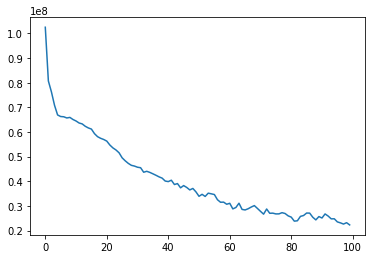

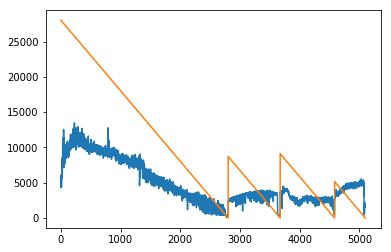

In [40]:
# %%capture outTrain
layersizes = [500,200,50]
expName = 'exp20180615'
model, history = trainModel_01(X_train, Y_train, layersizes, 100, expName)

In [ ]:
layersizes = [500,200,50]
expName = 'exp20180615'
mname = getModelName(epochs=100, kenmerk=expName, layersizes=layersizes)
model = load_model(mname)
predictions = model.predict(X_train)
plt.plot(predictions)
plt.plot(Y_train)
plt.show()

### Test modellen

##################
# Test: 1_4
##################
1139/1139 [==============================] - 0s 289us/step


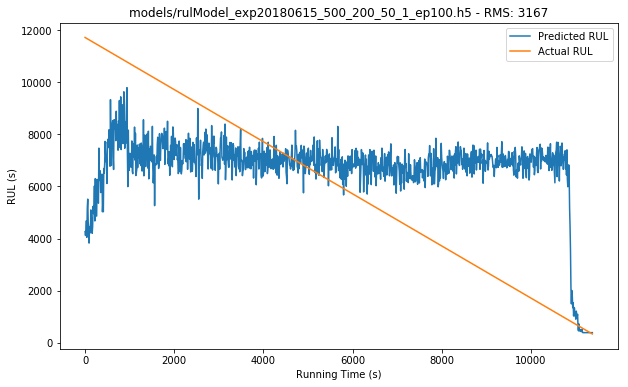

##################
# Test: 1_5
##################
2302/2302 [==============================] - 0s 210us/step


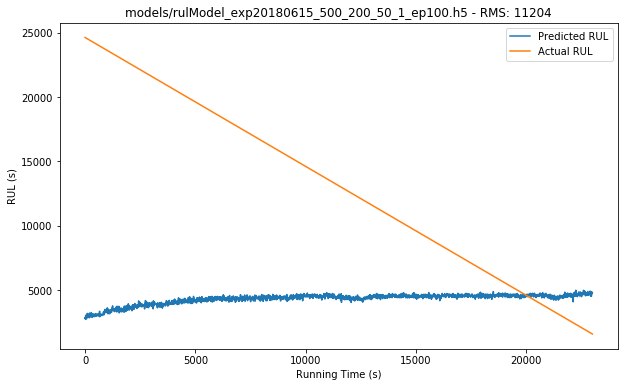

##################
# Test: 1_6
##################
2302/2302 [==============================] - 1s 244us/step


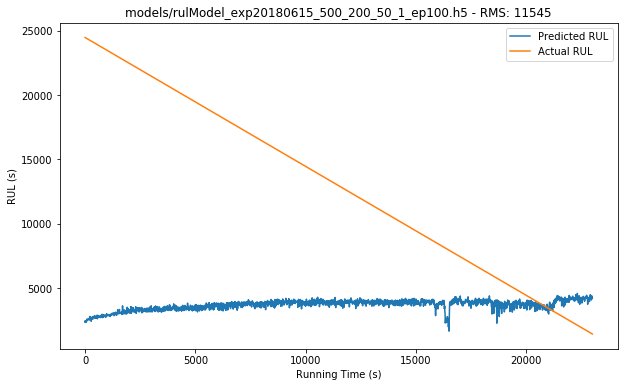

##################
# Test: 1_7
##################
1502/1502 [==============================] - 0s 281us/step


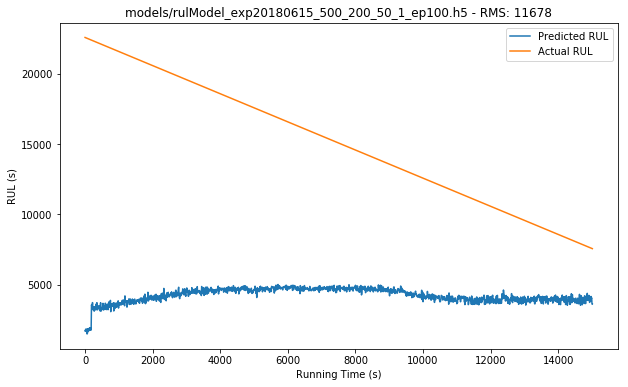

##################
# Test: 2_4
##################
612/612 [==============================] - 0s 613us/step


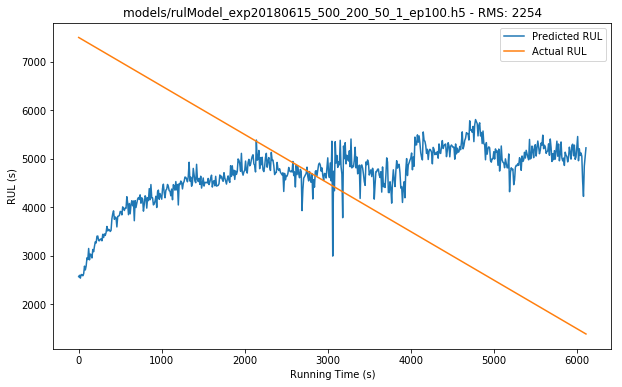

##################
# Test: 2_5
##################
2002/2002 [==============================] - 0s 219us/step


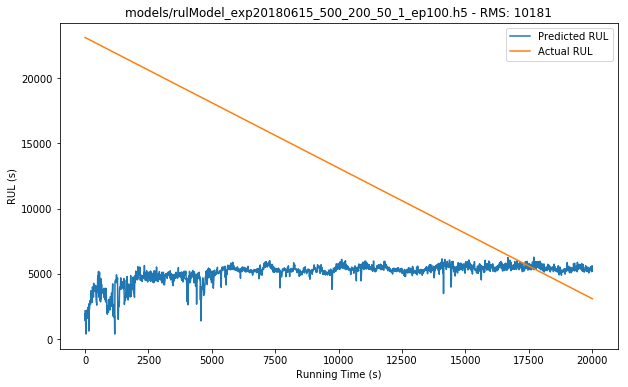

##################
# Test: 3_3
##################
352/352 [==============================] - 0s 1ms/step


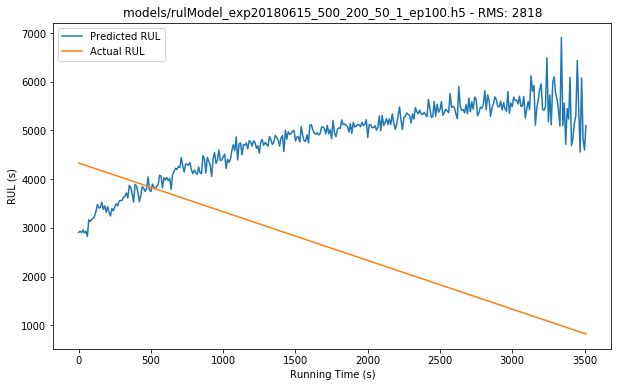

In [46]:
#%%capture outTest
layersizes = [500,200,50]
expName = 'exp20180615'
for testIndex in range(len(testspecs)):
    print('##################\n# Test: {:s}\n##################'.format(testspecs[testIndex][0]))
    actRUL =  testspecs[testIndex][1]
    testSpectro = np.concatenate((spectros_test_hor[testIndex], spectros_test_vert[testIndex], 
                                  test_temps[testIndex]), axis=1)
    modelnames = [getModelName(layersizes, 100, expName)]
    evaluate_spectro(modelnames, testSpectro, actRUL)